In [1]:
# imports
import numpy as np
import pandas as pd
from subgroup_detection import *
from subgroup_experiment import *
from agglomerative_subgroups import get_parkinsons_dataset, get_ccle_data, \
    get_performance_data, get_temperature_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor, RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import RFPlusMDI, AloRFPlusMDI
from scipy import cluster
from scipy.cluster.hierarchy import fcluster, cut_tree
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, \
    accuracy_score, r2_score, f1_score, log_loss, root_mean_squared_error
from imodels import get_clean_dataset
import openml
from ucimlrepo import fetch_ucirepo

In [2]:
ids = [361247, 361243, 361242, 361251, 361253, 361260, 361259, 361256, 361254, 361622]


In [3]:
task = openml.tasks.get_task(ids[0])
dataset = task.get_dataset()
X, y, _, cols = dataset.get_data(target=dataset.default_target_attribute,dataset_format="array")
# set X to first 2000 rows of X
X = X[:2000]
y = y[:2000]

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/scratch/users/zachrewolinski/conda/envs/mdi/lib/pytho

In [4]:
# get the data
# X, y, cols = get_clean_dataset(dataset_name = ids[1], data_source='openml')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)
# discern if the task is classification or regression
if len(np.unique(y)) == 2:
    task = 'classification'
else:
    task = 'regression'
    # convert y to float, if it is not already (ints will cause errors)
    y = y.astype(float)

In [5]:
def fit_models(X_train, y_train, task):
    # fit models
    if task == "classification":
        rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=3,
                                    max_features='sqrt', random_state=42)
        rf.fit(X_train, y_train)
        rf_plus_baseline = RandomForestPlusClassifier(rf_model=rf,
                                        include_raw=False, fit_on="inbag",
                                        prediction_model=LogisticRegression())
        rf_plus_baseline.fit(X_train, y_train)
        rf_plus = RandomForestPlusClassifier(rf_model=rf)
        rf_plus.fit(X_train, y_train)
    elif task == "regression":
        rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5,
                                   max_features=0.33, random_state=42)
        rf.fit(X_train, y_train)
        rf_plus_baseline = RandomForestPlusRegressor(rf_model=rf,
                                        include_raw=False, fit_on="inbag",
                                        prediction_model=LinearRegression())
        rf_plus_baseline.fit(X_train, y_train)
        rf_plus = RandomForestPlusRegressor(rf_model=rf)
        rf_plus.fit(X_train, y_train)
    else:
        raise ValueError("Task must be either 'classification' or 'regression'.")
    return rf, rf_plus_baseline, rf_plus

In [6]:
rf, rf_plus_baseline, rf_plus = fit_models(X_train, y_train, task)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 73 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 78 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller value

In [7]:
def get_shap(X, shap_explainer, task):
    if task == "classification":
        # the shap values are an array of shape
        # (# of samples, # of features, # of classes), and in this binary
        # classification case, we want the shap values for the positive class.
        # check_additivity=False is used to speed up computation.
        shap_values = \
            shap_explainer.shap_values(X, check_additivity=False)[:, :, 1]
    else:
        # check_additivity=False is used to speed up computation.
        shap_values = shap_explainer.shap_values(X, check_additivity=False)
    # get the rankings of the shap values. negative absolute value is taken
    # because np.argsort sorts from smallest to largest.
    shap_rankings = np.argsort(-np.abs(shap_values), axis = 1)
    return shap_values, shap_rankings

In [8]:
shap_explainer = shap.TreeExplainer(rf)
shap_values, shap_rankings = get_shap(X_train, shap_explainer, task)

In [9]:
def get_lmdi(X, y, lmdi_explainer, l2norm, sign, normalize, leaf_average, ranking=False):
    # get feature importances
    lmdi = lmdi_explainer.explain_linear_partial(X, y, l2norm=l2norm, sign=sign,
                                                 normalize=normalize,
                                                 leaf_average=leaf_average,
                                                 ranking=ranking)
    mdi_rankings = lmdi_explainer.get_rankings(np.abs(lmdi))
    return lmdi, mdi_rankings

In [10]:
lmdi_explainer_signed_normalized_l2_avg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_signed_normalized_l2_noavg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_signed_nonnormalized_l2_avg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_signed_nonnormalized_l2_noavg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonl2_avg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonl2_noavg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_l2_ranking = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonl2_ranking = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_l2_ranking_nonloo = RFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonl2_ranking_nonloo = RFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_normalized_l2_ranking = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonnormalized_l2_ranking = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_baseline_explainer = RFPlusMDI(rf_plus_baseline, mode = "only_k", evaluate_on = "inbag")
lmdi_values_signed_normalized_l2_avg, \
    lmdi_rankings_signed_normalized_l2_avg = \
        get_lmdi(X_train, y_train, lmdi_explainer_signed_normalized_l2_avg,
                    l2norm=True, sign=True, normalize=True, leaf_average=True)
lmdi_values_signed_normalized_l2_noavg, \
    lmdi_rankings_signed_normalized_l2_noavg = \
        get_lmdi(X_train, y_train,lmdi_explainer_signed_normalized_l2_noavg,
                    l2norm=True, sign=True, normalize=True, leaf_average=False)
lmdi_values_signed_nonnormalized_l2_avg, \
    lmdi_rankings_signed_nonnormalized_l2_avg = \
        get_lmdi(X_train,y_train,lmdi_explainer_signed_nonnormalized_l2_avg,
                    l2norm=True, sign=True, normalize=False, leaf_average=True)
lmdi_values_signed_nonnormalized_l2_noavg, \
    lmdi_rankings_signed_nonnormalized_l2_noavg = \
        get_lmdi(X_train, y_train,
                    lmdi_explainer_signed_nonnormalized_l2_noavg, l2norm=True,
                    sign=True, normalize=False, leaf_average=False)
lmdi_values_nonl2_avg, lmdi_rankings_nonl2_avg = \
    get_lmdi(X_train, y_train, lmdi_explainer_nonl2_avg, l2norm=False,
                sign=False, normalize=False, leaf_average=True)
lmdi_values_nonl2_noavg, lmdi_rankings_nonl2_noavg = \
    get_lmdi(X_train, y_train, lmdi_explainer_nonl2_noavg, l2norm=False,
                sign=False, normalize=False, leaf_average=False)
lmdi_values_l2_ranking, lmdi_rankings_l2_ranking = \
    get_lmdi(X_train, y_train, lmdi_explainer_l2_ranking, l2norm=True,
                sign=False, normalize=False, leaf_average=False, ranking=True)
lmdi_values_nonl2_ranking, lmdi_rankings_nonl2_ranking = \
    get_lmdi(X_train, y_train, lmdi_explainer_nonl2_ranking, l2norm=False,
                sign=False, normalize=False, leaf_average=False, ranking=True)
lmdi_values_l2_ranking_nonloo, lmdi_rankings_l2_ranking_nonloo = \
    get_lmdi(X_train, y_train, lmdi_explainer_l2_ranking_nonloo, l2norm=True,
                sign=False, normalize=False, leaf_average=False, ranking=True)
lmdi_values_nonl2_ranking_nonloo, lmdi_rankings_nonl2_ranking_nonloo = \
    get_lmdi(X_train, y_train, lmdi_explainer_nonl2_ranking_nonloo, l2norm=False,
                sign=False, normalize=False, leaf_average=False, ranking=True)
lmdi_values_normalized_l2_ranking, lmdi_rankings_normalized_l2_ranking = \
    get_lmdi(X_train, y_train, lmdi_explainer_normalized_l2_ranking, l2norm=True,
                sign=False, normalize=True, leaf_average=False, ranking=True)
lmdi_values_baseline, lmdi_rankings_baseline = \
    get_lmdi(X_train, y_train, lmdi_baseline_explainer, l2norm=False,
                sign=False, normalize=False, leaf_average=False)

In [11]:
# create storage for iteration purposes
lfi_values = \
    {'shap': shap_values,
        # 'signed_normalized_l2_avg': lmdi_values_signed_normalized_l2_avg,
        # 'signed_normalized_l2_noavg': lmdi_values_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': lmdi_values_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            lmdi_values_signed_nonnormalized_l2_noavg,
        'nonl2_avg': lmdi_values_nonl2_avg,
        'nonl2_noavg': lmdi_values_nonl2_noavg,
        'l2_ranking': lmdi_values_l2_ranking,
        'nonl2_ranking': lmdi_values_nonl2_ranking,
        'l2_ranking_nonloo': lmdi_values_l2_ranking_nonloo,
        'nonl2_ranking_nonloo': lmdi_values_nonl2_ranking_nonloo,
        # 'normalized_l2_ranking': lmdi_values_normalized_l2_ranking,
        # 'normalized_nonl2_ranking': lmdi_values_normalized_nonl2_ranking,
        'baseline': lmdi_values_baseline}
lfi_rankings = \
    {'shap': shap_rankings,
        'signed_normalized_l2_avg': lmdi_rankings_signed_normalized_l2_avg,
        'signed_normalized_l2_noavg': lmdi_rankings_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': lmdi_rankings_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            lmdi_rankings_signed_nonnormalized_l2_noavg,
        'nonl2_avg': lmdi_rankings_nonl2_avg,
        'nonl2_noavg': lmdi_rankings_nonl2_noavg,
        'l2_ranking': lmdi_rankings_l2_ranking,
        'nonl2_ranking': lmdi_rankings_nonl2_ranking,
    #  'normalized_l2_ranking': lmdi_values_normalized_l2_ranking,
    #  'normalized_nonl2_ranking': lmdi_values_normalized_nonl2_ranking,
        'baseline': lmdi_rankings_baseline}

In [12]:
test_shap_values, test_shap_rankings = get_shap(X_test, shap_explainer, task)
test_lmdi_values_signed_normalized_l2_avg, \
    test_lmdi_rankings_signed_normalized_l2_avg = \
        get_lmdi(X_test, None, lmdi_explainer_signed_normalized_l2_avg,
                    l2norm=True, sign=True, normalize=True, leaf_average=True)
test_lmdi_values_signed_normalized_l2_noavg, \
    test_lmdi_rankings_signed_normalized_l2_noavg = \
        get_lmdi(X_test, None,lmdi_explainer_signed_normalized_l2_noavg,
                    l2norm=True, sign=True, normalize=True, leaf_average=False)
test_lmdi_values_signed_nonnormalized_l2_avg, \
    test_lmdi_rankings_signed_nonnormalized_l2_avg = \
        get_lmdi(X_test, None,lmdi_explainer_signed_nonnormalized_l2_avg,
                    l2norm=True, sign=True, normalize=False, leaf_average=True)
test_lmdi_values_signed_nonnormalized_l2_noavg, \
    test_lmdi_rankings_signed_nonnormalized_l2_noavg = \
        get_lmdi(X_test, None,
                    lmdi_explainer_signed_nonnormalized_l2_noavg, l2norm=True,
                    sign=True, normalize=False, leaf_average=False)
test_lmdi_values_nonl2_avg, test_lmdi_rankings_nonl2_avg = \
    get_lmdi(X_test, None, lmdi_explainer_nonl2_avg, l2norm=False,
                sign=False, normalize=False, leaf_average=True)
test_lmdi_values_nonl2_noavg, test_lmdi_rankings_nonl2_noavg = \
    get_lmdi(X_test, None, lmdi_explainer_nonl2_noavg, l2norm=False,
                sign=False, normalize=False, leaf_average=False)
test_lmdi_values_l2_ranking, test_lmdi_rankings_l2_ranking = \
    get_lmdi(X_test, None, lmdi_explainer_l2_ranking, l2norm=True,
                sign=False, normalize=False, leaf_average=False, ranking=True)
test_lmdi_values_nonl2_ranking, test_lmdi_rankings_nonl2_ranking = \
    get_lmdi(X_test, None, lmdi_explainer_nonl2_ranking, l2norm=False,
                sign=False, normalize=False, leaf_average=False, ranking=True)
test_lmdi_values_l2_ranking_nonloo, test_lmdi_rankings_l2_ranking_nonloo = \
    get_lmdi(X_test, None, lmdi_explainer_l2_ranking_nonloo, l2norm=True,
                sign=False, normalize=False, leaf_average=False, ranking=True)
test_lmdi_values_nonl2_ranking_nonloo, test_lmdi_rankings_nonl2_ranking_nonloo = \
    get_lmdi(X_test, None, lmdi_explainer_nonl2_ranking_nonloo, l2norm=False,
                sign=False, normalize=False, leaf_average=False, ranking=True)
test_lmdi_values_normalized_l2_ranking, test_lmdi_rankings_normalized_l2_ranking = \
    get_lmdi(X_test, None, lmdi_explainer_normalized_l2_ranking, l2norm=True,
                sign=False, normalize=True, leaf_average=False, ranking=True)
test_lmdi_values_baseline, test_lmdi_rankings_baseline = \
    get_lmdi(X_test, None, lmdi_baseline_explainer, l2norm=False,
                sign=False, normalize=False, leaf_average=False)

In [13]:
# create storage for iteration purposes
test_lfi_values = \
    {'shap': test_shap_values,
        # 'signed_normalized_l2_avg': test_lmdi_values_signed_normalized_l2_avg,
        # 'signed_normalized_l2_noavg': test_lmdi_values_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': test_lmdi_values_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            test_lmdi_values_signed_nonnormalized_l2_noavg,
        'nonl2_avg': test_lmdi_values_nonl2_avg,
        'nonl2_noavg': test_lmdi_values_nonl2_noavg,
        'l2_ranking': test_lmdi_values_l2_ranking,
        'nonl2_ranking': test_lmdi_values_nonl2_ranking,
        'l2_ranking_nonloo': test_lmdi_values_l2_ranking_nonloo,
        'nonl2_ranking_nonloo': test_lmdi_values_nonl2_ranking_nonloo,
        # 'normalized_l2_ranking': test_lmdi_values_normalized_l2_ranking,
        # 'normalized_nonl2_ranking': lmdi_values_normalized_nonl2_ranking,
        'baseline': test_lmdi_values_baseline}
test_lfi_rankings = \
    {'shap': test_shap_rankings,
        'signed_normalized_l2_avg': test_lmdi_rankings_signed_normalized_l2_avg,
        'signed_normalized_l2_noavg': test_lmdi_rankings_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': test_lmdi_rankings_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            test_lmdi_rankings_signed_nonnormalized_l2_noavg,
        'nonl2_avg': test_lmdi_rankings_nonl2_avg,
        'nonl2_noavg': test_lmdi_rankings_nonl2_noavg,
        'l2_ranking': test_lmdi_rankings_l2_ranking,
        'nonl2_ranking': test_lmdi_rankings_nonl2_ranking,
    #  'normalized_l2_ranking': lmdi_values_normalized_l2_ranking,
    #  'normalized_nonl2_ranking': lmdi_values_normalized_nonl2_ranking,
        'baseline': test_lmdi_rankings_baseline}

In [14]:
values_linkage = {}
for method, values in lfi_values.items():
    # values_linkage[method] = sch.linkage(values, method="ward")
    values_linkage[method] = cluster.hierarchy.ward(values)

In [15]:
# get clusters for values
value_clusters = {}
for method, link in values_linkage.items():
    num_cluster_map = {}
    for num_clusters in range(2, 11):
        # num_cluster_map[num_clusters] = fcluster(link, num_clusters,
        #                                          criterion = "maxclust")
        num_cluster_map[num_clusters] = cut_tree(link, n_clusters=num_clusters).flatten()
    value_clusters[method] = num_cluster_map

In [16]:
# for each method, for each number of clusters, get the clusters and compute their centroids
value_centroids = {}
for method, clusters in value_clusters.items():
    num_cluster_centroids = {}
    for num_clusters, cluster_labels in clusters.items():
        centroids = np.zeros((num_clusters, X.shape[1]))
        for cluster_num in range(num_clusters):
            cluster_indices = np.where(cluster_labels == cluster_num)[0]
            cluster_values = lfi_values[method][cluster_indices]
            centroids[cluster_num] = np.mean(cluster_values, axis = 0)
        num_cluster_centroids[num_clusters] = centroids
    value_centroids[method] = num_cluster_centroids

In [17]:
# for each method, for its test values, assign the test values to the closest centroid
test_value_clusters = {}
for method, centroids in value_centroids.items():
    num_cluster_map = {}
    for num_clusters, centroid_values in centroids.items():
        test_clusters = np.zeros(len(test_lfi_values[method]))
        for i, test_value in enumerate(test_lfi_values[method]):
            distances = np.linalg.norm(centroid_values - test_value, axis = 1)
            test_clusters[i] = np.argmin(distances)
        num_cluster_map[num_clusters] = test_clusters
    test_value_clusters[method] = num_cluster_map

In [18]:
# using original data, split train and test set into clusters according to each method
train_clusters = {}
for method, clusters in value_clusters.items():
    num_cluster_map = {}
    for num_clusters, cluster_labels in clusters.items():
        cluster_map = {}
        for cluster_num in range(num_clusters):
            cluster_indices = np.where(cluster_labels == cluster_num)[0]
            cluster_map[cluster_num] = cluster_indices
        num_cluster_map[num_clusters] = cluster_map
    train_clusters[method] = num_cluster_map
test_clusters = {}
for method, clusters in test_value_clusters.items():
    num_cluster_map = {}
    for num_clusters, cluster_labels in clusters.items():
        cluster_map = {}
        for cluster_num in range(num_clusters):
            cluster_indices = np.where(cluster_labels == cluster_num)[0]
            cluster_map[cluster_num] = cluster_indices
        num_cluster_map[num_clusters] = cluster_map
    test_clusters[method] = num_cluster_map

In [ ]:
train_clusters

{'shap': {2: {0: array([   0,    1,    2, ..., 1396, 1398, 1399]),
   1: array([   4,   14,   24,   33,   34,   50,   57,   62,   69,   71,   72,
            73,   75,   81,   83,   84,   85,   91,   95,  100,  117,  125,
           134,  136,  152,  157,  160,  161,  171,  173,  176,  180,  183,
           185,  188,  196,  198,  203,  204,  217,  223,  224,  225,  237,
           243,  256,  270,  279,  287,  293,  308,  313,  317,  319,  320,
           321,  326,  330,  333,  345,  349,  356,  358,  359,  364,  367,
           377,  379,  382,  387,  395,  406,  410,  415,  417,  440,  441,
           443,  447,  451,  457,  458,  466,  469,  470,  479,  481,  498,
           506,  514,  516,  519,  523,  524,  525,  531,  538,  541,  549,
           566,  568,  571,  576,  577,  584,  585,  586,  588,  593,  595,
           596,  600,  610,  613,  621,  625,  626,  632,  638,  642,  646,
           649,  651,  653,  656,  659,  660,  663,  671,  679,  681,  693,
           706,  7

: 

: 

In [ ]:
test_clusters

{'shap': {2: {0: array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  13,  14,
           15,  16,  17,  18,  19,  20,  21,  22,  25,  26,  27,  28,  29,
           30,  31,  32,  33,  34,  35,  36,  37,  39,  43,  45,  46,  49,
           51,  52,  53,  54,  56,  57,  58,  59,  61,  62,  63,  64,  65,
           66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
           79,  81,  82,  84,  86,  87,  88,  89,  92,  93,  95,  96,  97,
           98,  99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111,
          112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 127, 128,
          129, 132, 134, 135, 136, 137, 139, 140, 141, 142, 146, 147, 148,
          149, 151, 152, 153, 154, 155, 157, 158, 161, 162, 163, 164, 167,
          168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181,
          182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
          196, 197, 198, 199, 200, 202, 203, 207, 208, 210, 211, 212, 214,
          2

: 

: 

In [19]:
# for each method, for each number of clusters, train a linear model on the training set for each cluster and use it to predict the testing set for each cluster
train_test_accuracies = {}
train_test_r2 = {}
for method in train_clusters.keys():
    method_accuracies = {}
    method_r2s = {}
    for num_clusters in range(2, 11):
        r2 = []
        accuracy = []
        num_samples = []
        for cluster_idx in range(num_clusters):
            X_cluster_train = X_train[train_clusters[method][num_clusters][cluster_idx]]
            y_cluster_train = y_train[train_clusters[method][num_clusters][cluster_idx]]
            X_cluster_test = X_test[test_clusters[method][num_clusters][cluster_idx]]
            y_cluster_test = y_test[test_clusters[method][num_clusters][cluster_idx]]
            if X_cluster_test.shape[0] == 0:
                continue
            if task == "classification":
                model = LogisticRegression()
            else:
                model = LinearRegression()
            model.fit(X_cluster_train, y_cluster_train)
            cluster_predictions = model.predict(X_cluster_test)
            # get model accuracy
            if task == "classification":
                accuracy.append(accuracy_score(y_cluster_test, cluster_predictions))
            else:
                rmse = root_mean_squared_error(y_cluster_test, cluster_predictions)
                print(f"RMSE for {method} w/ Cluster {cluster_idx+1}/{num_clusters} is {rmse}.")
                accuracy.append(root_mean_squared_error(y_cluster_test, cluster_predictions))
                r2.append(r2_score(y_cluster_test, cluster_predictions))
            num_samples.append(X_cluster_test.shape[0])
        method_accuracies[num_clusters] = weighted_metric(np.array(accuracy), np.array(num_samples))
        method_r2s[num_clusters] = weighted_metric(np.array(r2), np.array(num_samples))
    # average accuracy across clusters
    train_test_accuracies[method] = method_accuracies
    train_test_r2[method] = method_r2s

RMSE for shap w/ Cluster 1/2 is 0.0011445284932732054.
RMSE for shap w/ Cluster 2/2 is 0.0009922498157503208.
RMSE for shap w/ Cluster 1/3 is 0.027281400903993308.
RMSE for shap w/ Cluster 2/3 is 0.009942837383779714.
RMSE for shap w/ Cluster 3/3 is 0.000994189767380801.
RMSE for shap w/ Cluster 1/4 is 0.0009196394707618619.
RMSE for shap w/ Cluster 2/4 is 5.560614551822814e-05.
RMSE for shap w/ Cluster 3/4 is 0.011793098028449795.
RMSE for shap w/ Cluster 4/4 is 0.03515880072413344.
RMSE for shap w/ Cluster 1/5 is 6.491663718862225e-05.
RMSE for shap w/ Cluster 2/5 is 5.458092742669756e-05.
RMSE for shap w/ Cluster 3/5 is 0.004552416992647418.
RMSE for shap w/ Cluster 4/5 is 0.02673274375572193.
RMSE for shap w/ Cluster 5/5 is 0.03579808908925724.
RMSE for shap w/ Cluster 1/6 is 6.491663718862225e-05.
RMSE for shap w/ Cluster 2/6 is 5.458092742669756e-05.
RMSE for shap w/ Cluster 3/6 is 0.007584884108137434.
RMSE for shap w/ Cluster 4/6 is 0.0004192880871736979.
RMSE for shap w/ Clust

In [ ]:
train_test_accuracies

{'shap': {2: 86.61862554046574,
  3: 76.26400990618936,
  4: 81.50552937094741,
  5: 1045.9281421999347,
  6: 1783.4559847177343,
  7: 1779.2898374341335,
  8: 1138.1924065568594,
  9: 1143.5602298235876,
  10: 2372.6308743301242},
 'signed_nonnormalized_l2_avg': {2: 24.953502111873004,
  3: 362.23399172452343,
  4: 381.0593692158767,
  5: 486.2769066190062,
  6: 522.023542752005,
  7: 1803.3453095303553,
  8: 1491.8768329672278,
  9: 1538.0817941453593,
  10: 1690.110392265115},
 'signed_nonnormalized_l2_noavg': {2: 25.54774620816979,
  3: 270.55857754353457,
  4: 363.85662723771935,
  5: 496.31707728979035,
  6: 366.8079229401296,
  7: 376.44421691895076,
  8: 319.0252403141974,
  9: 1201.1033485099247,
  10: 1217.637018890846},
 'nonl2_avg': {2: 115.03388507029837,
  3: 374.35230063401576,
  4: 535.3206119738915,
  5: 446.8612771761584,
  6: 1213.6365571393274,
  7: 1223.372364938818,
  8: 1300.6500788958385,
  9: 1315.6993109788154,
  10: 888.7873827286251},
 'nonl2_noavg': {2: 22.

: 

: 

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


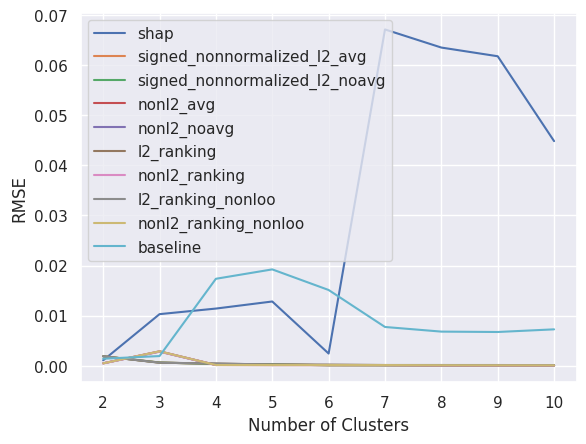

In [20]:
# plot the results such that each line has a unique color
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig, ax = plt.subplots()
for method, predictions in train_test_accuracies.items():
    ax.plot(list(predictions.keys()), list(predictions.values()), label = method)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("RMSE")
ax.legend()
plt.show()

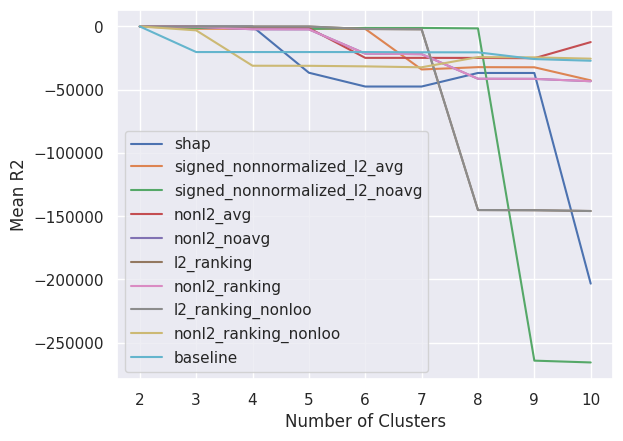

: 

: 

In [ ]:
# plot the results such that each line has a unique color
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig, ax = plt.subplots()
for method, predictions in train_test_r2.items():
    ax.plot(list(predictions.keys()), list(predictions.values()), label = method)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Mean R2")
ax.legend()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# for method, predictions in train_test_predictions.items():
#     if method == "l2_ranking":
#         continue
#     plt.plot(list(predictions.keys()), list(predictions.values()), label = method)
# plt.xlabel("Number of Clusters")
# plt.ylabel("Average Accuracy")
# plt.legend()
# plt.show()

: 

: 

: 

: 

: 

: 